In [1]:
import cv2
import math
import matplotlib.pyplot
import numpy
import os
import pathlib
import PIL
import skimage.morphology
import skimage.io
import sklearn
import sklearn.model_selection  
import sklearn.utils
import tensorflow

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)
from IPython.display import Image, display
from PIL import ImageOps
from keras.preprocessing.image import array_to_img

In [2]:
path_mask = "mask"
path_images = "images"
image_size = 400

def load_mask(filename):
    return numpy.float32(skimage.io.imread(filename) / 255)


def load_all_masks(path):
    return [load_mask(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]


def load_image(filename):
    return skimage.img_as_float32(skimage.io.imread(filename))


def load_all_images(path):
    return [load_image(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

In [3]:
def set_avx_avx2():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def set_gpu():
    gpus = tensorflow.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                print(f"GPU: {gpu.name}")
                tensorflow.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

In [4]:
class AugmentationSequence(tensorflow.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(numpy.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        aug_x = numpy.zeros(batch_x.shape)
        aug_y = numpy.zeros(batch_y.shape)

        for idx in range(batch_x.shape[0]):
            aug = self.augment(image=batch_x[idx, :, :, :], mask=batch_y[idx, :, :, :])
            aug_x[idx, :, :, :] = aug["image"]
            aug_y[idx, :, :, :] = aug["mask"]

        return aug_x, aug_y

In [5]:
def unet_model(keras=None, img_size=None):

    input_img = tensorflow.keras.layers.Input((img_size, img_size, 1), name = "img")

    # Contract #1
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(input_img)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    c1 = tensorflow.keras.layers.Dropout(0.1)(c1)
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c1)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    p1 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c1)

    # Contract #2
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p1)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    c2 = tensorflow.keras.layers.Dropout(0.2)(c2)
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c2)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    p2 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c2)

    # Contract #3
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p2)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    c3 = tensorflow.keras.layers.Dropout(0.3)(c3)
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c3)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    p3 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c3)

    # Contract #4
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p3)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    c4 = tensorflow.keras.layers.Dropout(0.4)(c4)
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c4)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    p4 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c4)

    # Middle
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p4)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)
    c5 = tensorflow.keras.layers.Dropout(0.5)(c5)
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c5)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)

    # Expand (upscale) #1
    u6 = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tensorflow.keras.layers.concatenate([u6, c4])
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)
    c6 = tensorflow.keras.layers.Dropout(0.5)(c6)
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)

    # Expand (upscale) #2
    u7 = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "same")(c6)
    u7 = tensorflow.keras.layers.concatenate([u7, c3])
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)
    c7 = tensorflow.keras.layers.Dropout(0.5)(c7)
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)

    # Expand (upscale) #3
    u8 = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = "same")(c7)
    u8 = tensorflow.keras.layers.concatenate([u8, c2])
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)
    c8 = tensorflow.keras.layers.Dropout(0.5)(c8)
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)

    # Expand (upscale) #4
    u9 = tensorflow.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "same")(c8)
    u9 = tensorflow.keras.layers.concatenate([u9, c1])
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)
    c9 = tensorflow.keras.layers.Dropout(0.5)(c9)
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)

    output = tensorflow.keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c9)
    model = tensorflow.keras.Model(inputs = [input_img], outputs = [output])
    return model

In [6]:
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true) + tensorflow.keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss


def dice_coef(y_true, y_pred, smooth = 1):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true), -1) + tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

In [7]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    print(f"i.shape {i.shape}")
    mask = numpy.argmax(i, axis=-1)
    mask = numpy.expand_dims(mask, axis=-1)
    print(f"mask.shape {mask.shape}")
    img = PIL.ImageOps.autocontrast(array_to_img(mask))
    img.save(f"mask.jpg")
    display(img)

images[50].shape: (400, 400)
masks[50].shape: (400, 400)


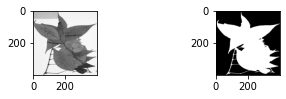

In [8]:
images = load_all_images(path_images)
masks = load_all_masks(path_mask)


print(f"images[50].shape: {images[50].shape}")
print(f"masks[50].shape: {masks[50].shape}")
f = matplotlib.pyplot.figure()
f.add_subplot(3, 2, 1)
matplotlib.pyplot.imshow(images[50], cmap = "gray")
f.add_subplot(3, 2, 2)
matplotlib.pyplot.imshow(masks[50], cmap = "gray")

In [9]:
X = numpy.array(images).reshape(len(images), image_size, image_size, 1)
Y = numpy.array(masks).reshape(len(masks), image_size, image_size, 1)
X, Y = sklearn.utils.shuffle(X, Y, random_state=1234)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.05, random_state=1234)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.05, random_state=1234)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X.shape)

(338, 400, 400, 1)
(18, 400, 400, 1)
(19, 400, 400, 1)
(375, 400, 400, 1)


In [10]:
images_test_ids = []

nimages = X_test.shape[0]
for idx in range(nimages):
  test_image = X_test[idx,:,:,0]
  if any(numpy.array_equal(test_image, x) for x in images):
    images_test_ids.append(idx)


/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


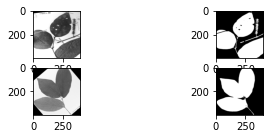

In [11]:
augment = Compose([
        HorizontalFlip(),
        ShiftScaleRotate(rotate_limit=45, border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(border_mode=cv2.BORDER_CONSTANT),
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ])

batch_size = 16
train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)
reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau( monitor="loss", factor=0.5, patience=3, verbose=1 )

X_aug, Y_aug = train_generator.__getitem__(20)
f = matplotlib.pyplot.figure()
f.add_subplot(4, 2, 1)
matplotlib.pyplot.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 2)
matplotlib.pyplot.imshow(Y_aug[0,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 3)
matplotlib.pyplot.imshow(X_aug[1,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 4)
matplotlib.pyplot.imshow(Y_aug[1,:,:,0], cmap = "gray")


In [15]:


reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau(
  monitor = "loss", 
  factor = 0.5, 
  patience = 3, 
  verbose = 1
)

checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(
  "model/unet.h5", 
  verbose = 1, 
  save_best_only = True
)

tensorflow.keras.backend.clear_session()
strategy = tensorflow.distribute.MirroredStrategy()

if (os.path.exists("model/unet.h5")):
  model = tensorflow.keras.models.load_model("model/unet.h5",
    custom_objects = {
      "jaccard_distance_loss": jaccard_distance_loss,
      "dice_coef": dice_coef
    }
  )
  
else:
  with strategy.scope():
    model = unet_model()
    adam_opt = tensorflow.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])
    
  fit = model.fit(train_generator, 
    steps_per_epoch = steps_per_epoch, 
    epochs = 100,
    validation_data = (X_val, Y_val),
    callbacks = [
      checkpointer,
      reduce_learning_rate
    ]
  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [13]:
def crop_image(img, mask):
  crop_mask = mask > 0
  m, n = mask.shape
  crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
  col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
  row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
  return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]

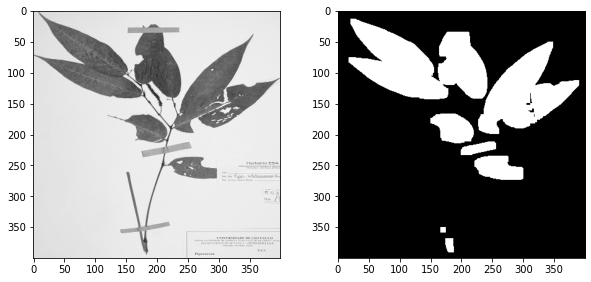

In [21]:
idx = 15
test_img = X_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
pred_mask = model.predict(test_img)[0,:,:,0]
pred_mask = numpy.uint8(pred_mask > 0.5)
open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask)

crop_img_masked = crop_img * crop_mask

# row, column
f = matplotlib.pyplot.figure(figsize=(10, 10))
f.add_subplot(2, 2, 1)
matplotlib.pyplot.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(2, 2, 2)
matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")

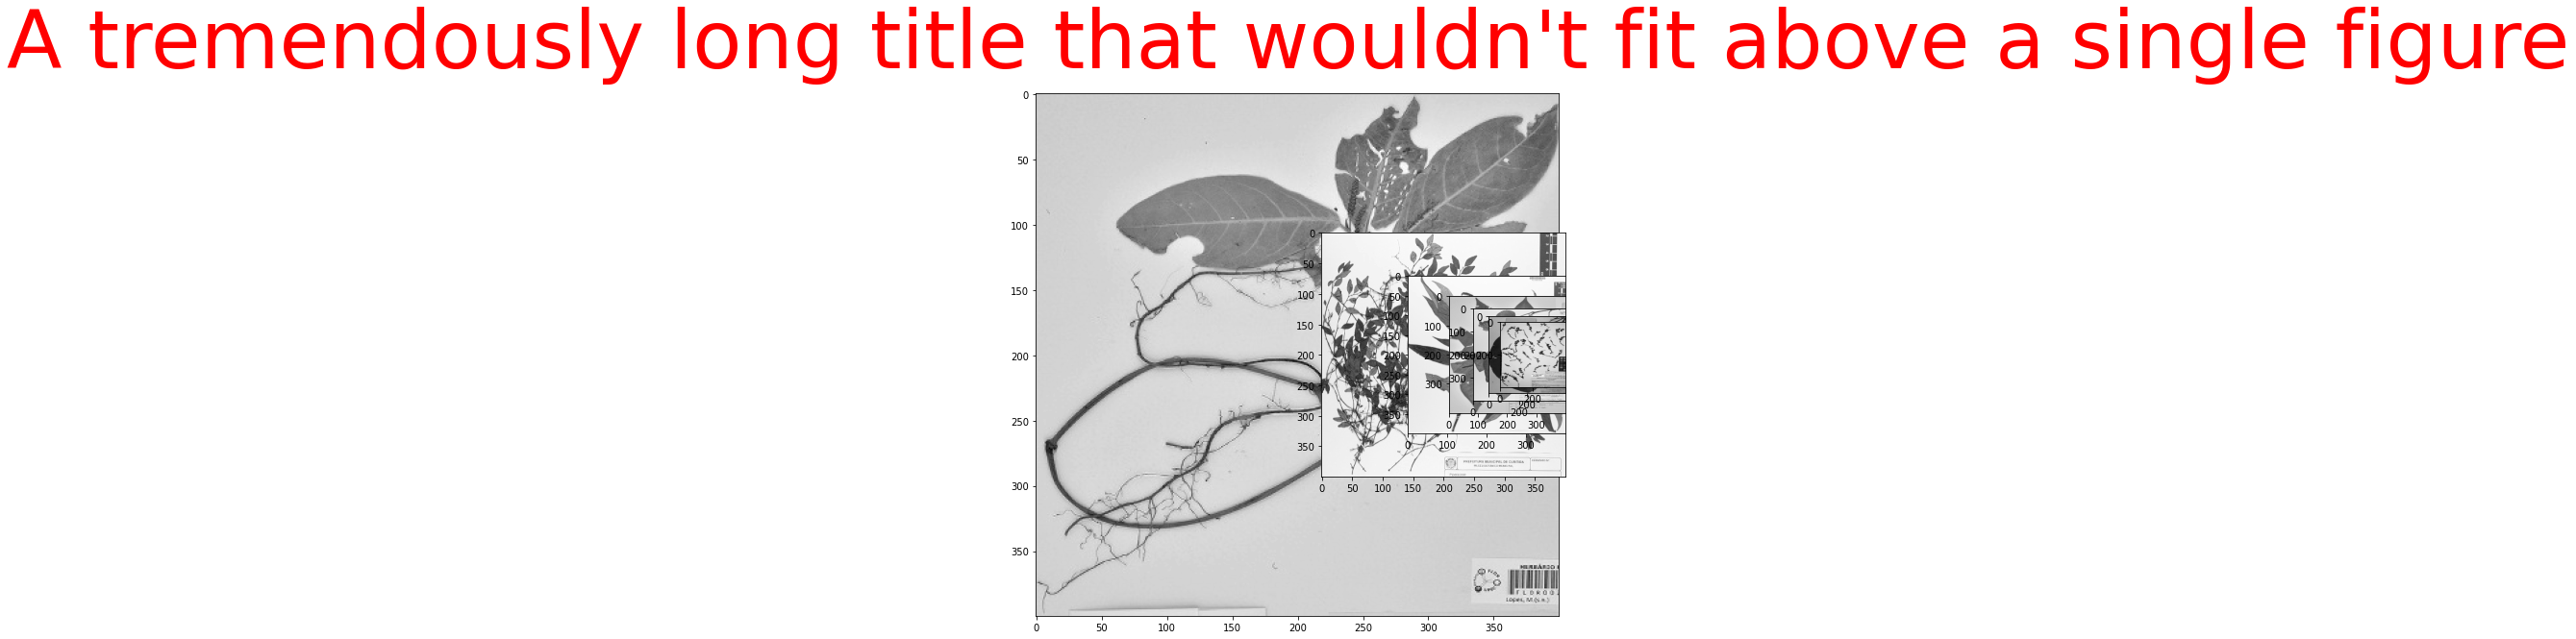

In [117]:
idx = 15
f, axarr = matplotlib.pyplot.subplots(nrows=3, ncols=8, figsize=(80, 30))
matplotlib.pyplot.figtext(0.5,0.95, "A tremendously long title that wouldn't fit above a single figure", ha="center", va="center", fontsize=84, color="r")
for i in range(8):
    test_img = X_test[i,:,:,:].reshape((1, image_size, image_size, 1))
    axarr[0, i].imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")

for i in range(8):
    test_mask = Y_test[i,:,:,:].reshape((1, image_size, image_size, 1))
    axarr[1, i].imshow(skimage.img_as_ubyte(test_mask[0,:,:,0]), cmap = "gray")

for i in range(8):
    test_img = X_test[i,:,:,:].reshape((1, image_size, image_size, 1))
    # test_mask = Y_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
    pred_mask = model.predict(test_img)[0,:,:,0]
    pred_mask = numpy.uint8(pred_mask > 0.5)
    open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
    open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
    post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
    axarr[2, i].imshow(post_pred_mask, cmap = "gray")
    # print(type(post_pred_mask))


f.savefig("a.png")

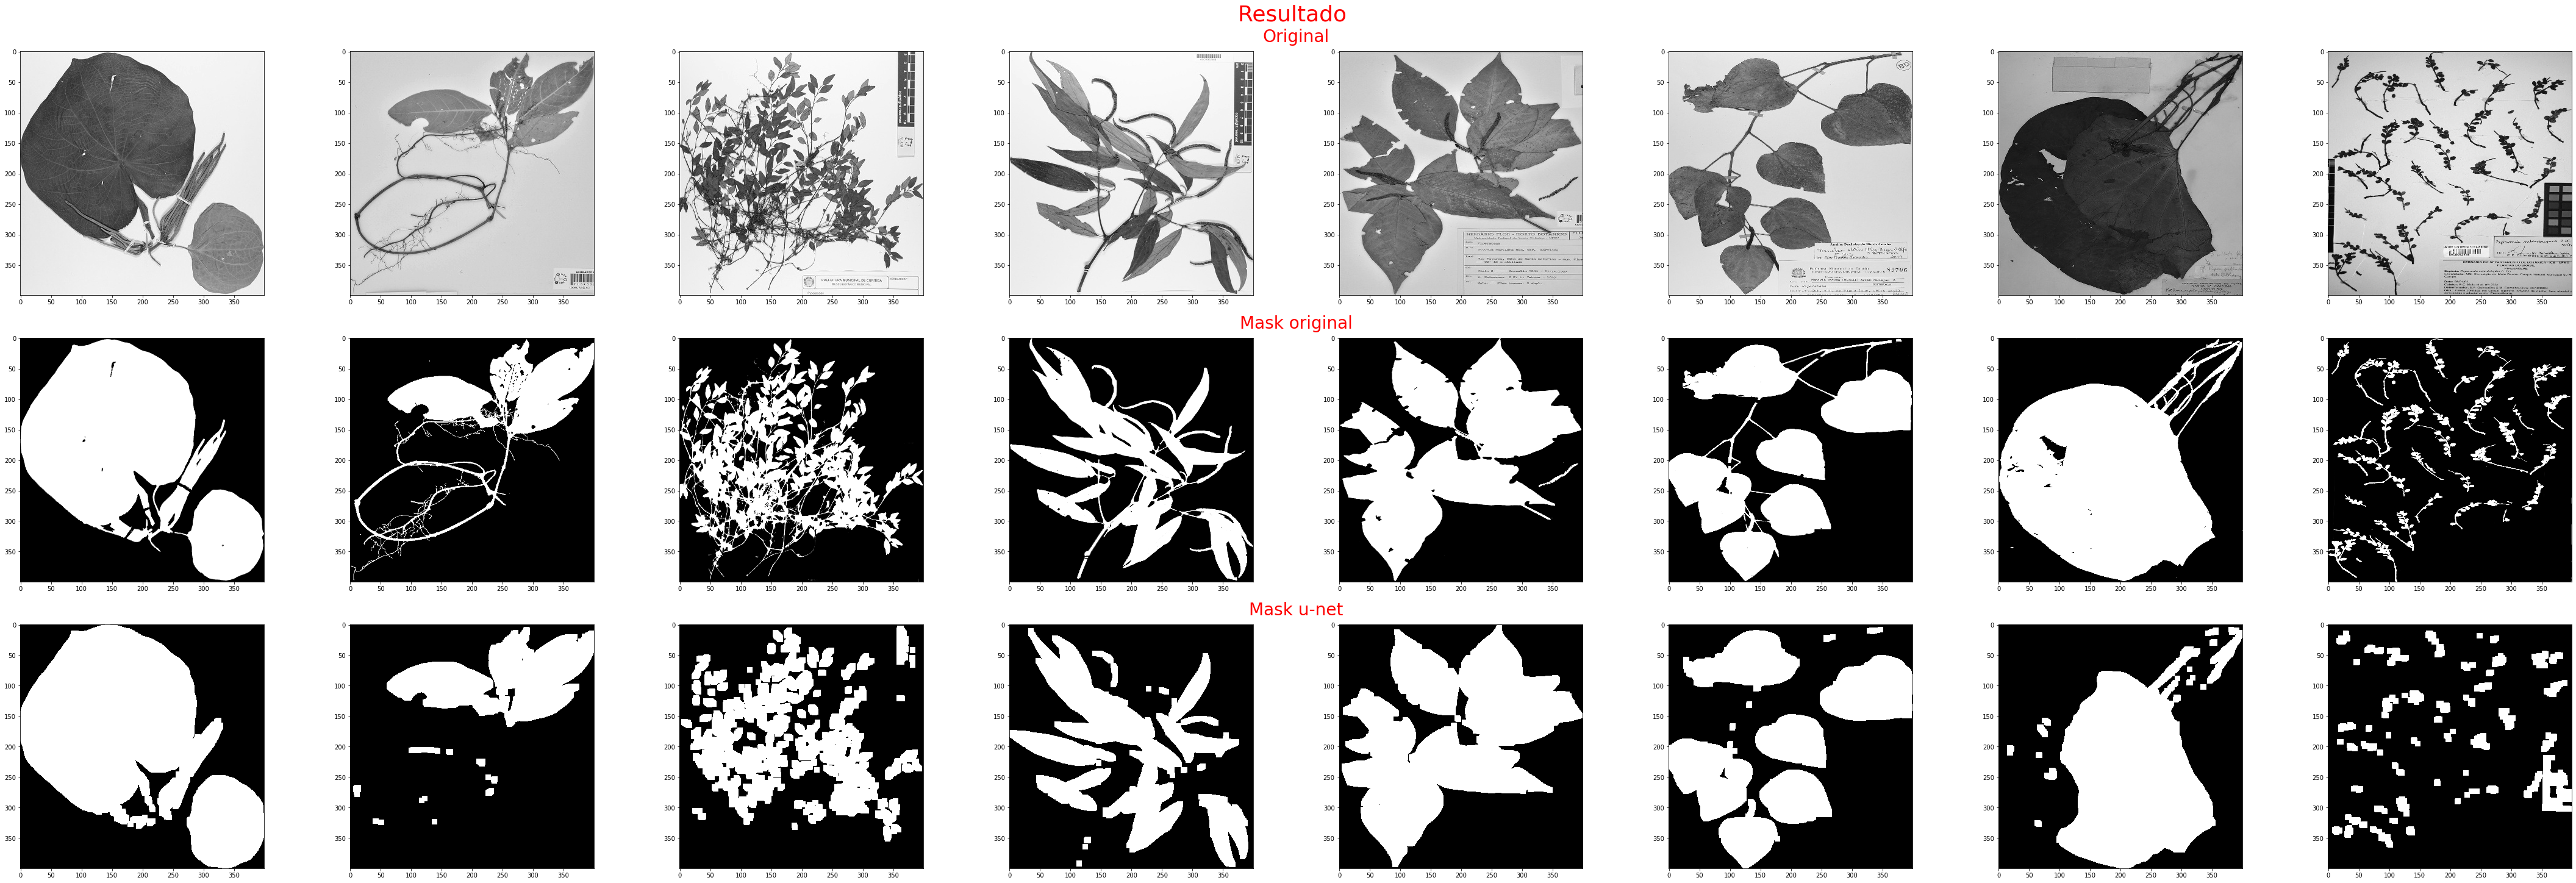

In [175]:

fig = matplotlib.pyplot.figure(constrained_layout=True, figsize=(60, 20))
fig.suptitle(f"Resultado ", fontsize=36, color="r")

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
titles =  ["Original", "Mask original", "Mask u-net"]
for i, subfig in enumerate(subfigs):
    subfig.suptitle(titles[i], fontsize=28, color="r")

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=8)
    for j, ax in enumerate(axs):
        if i == 0:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
        elif i == 1:
            test_mask = Y_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_mask[0,:,:,0]), cmap = "gray")
        elif i == 2:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            # test_mask = Y_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
            pred_mask = model.predict(test_img)[0,:,:,0]
            pred_mask = numpy.uint8(pred_mask > 0.5)
            open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
            open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
            post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
            ax.imshow(post_pred_mask, cmap = "gray")
        # ax.set_title(f'Plot title {col}')
        